## Uczenie maszynowe UMZ 2018/2019
### 7 kwietnia 2020
# 5. Dobre praktyki w uczeniu maszynowym

## 5.1. Metodologia testowania

W uczeniu maszynowym bardzo ważna jest ewaluacja budowanego modelu. Dlatego dobrze jest podzielić posiadane dane na odrębne zbiory – osobny zbiór danych do uczenia i osobny do testowania. W niektórych przypadkach potrzeba będzie dodatkowo wyodrębnić tzw. zbiór walidacyjny.

### Zbiór uczący a zbiór testowy

* Na zbiorze uczącym (treningowym) uczymy algorytmy, a na zbiorze testowym sprawdzamy ich poprawność.
* Zbiór uczący powinien być kilkukrotnie większy od testowego (np. 4:1, 9:1 itp.).
* Zbiór testowy często jest nieznany.
* Należy unikać mieszania danych testowych i treningowych – nie wolno „zanieczyszczać” danych treningowych danymi testowymi!

Czasami potrzebujemy dobrać parametry modelu, np. $\alpha$ – który zbiór wykorzystać do tego celu?

### Zbiór walidacyjny

Do doboru parametrów najlepiej użyć jeszcze innego zbioru – jest to tzw. **zbiór walidacyjny**

 * Zbiór walidacyjny powinien mieć wielkość zbliżoną do wielkości zbioru testowego, czyli np. dane można podzielić na te trzy zbiory w proporcjach 3:1:1, 8:1:1 itp.

### Walidacja krzyżowa

Którą część danych wydzielić jako zbiór walidacyjny tak, żeby było „najlepiej”?

 * Niech każda partia danych pełni tę rolę naprzemiennie!

<img width="100%" src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png"/>
Żródło: https://chrisjmccormick.wordpress.com/2013/07/31/k-fold-cross-validation-with-matlab-code/

### Walidacja krzyżowa

* Podziel dane $D = \left\{ (x^{(1)}, y^{(1)}), \ldots, (x^{(m)}, y^{(m)})\right\} $ na $N$ rozłącznych zbiorów $T_1,\ldots,T_N$
* Dla $i=1,\ldots,N$, wykonaj:
    * Użyj $T_i$ do walidacji i zbiór $S_i$ do trenowania, gdzie $S_i = D \smallsetminus T_i$. 
    * Zapisz model $\theta_i$.
* Akumuluj wyniki dla modeli $\theta_i$ dla zbiorów $T_i$.
* Ustalaj parametry uczenia na akumulowanych wynikach.

### Walidacja krzyżowa – wskazówki

* Zazwyczaj ustala się $N$ w przedziale od $4$ do $10$, tzw. $N$-krotna walidacja krzyżowa (_$N$-fold cross validation_). 
* Zbiór $D$ warto zrandomizować przed podziałem.
* W jaki sposób akumulować wyniki dla wszystkich zbiórow $T_i$?
* Po ustaleniu parametrów dla każdego $T_i$, trenujemy model na całych danych treningowych z ustalonymi parametrami.
* Testujemy na zbiorze testowym (jeśli nim dysponujemy).

### _Leave-one-out_

Jest to szczególny przypadek walidacji krzyżowej, w której $N = m$.

* Jaki jest rozmiar pojedynczego zbioru $T_i$?
* Jakie są zalety i wady tej metody?
* Kiedy może być przydatna?

### Zbiór walidujący a algorytmy optymalizacji

* Gdy błąd rośnie na zbiorze uczącym, mamy źle dobrany parametr $\alpha$. Należy go wtedy zmniejszyć.
* Gdy błąd zmniejsza się na zbiorze trenującym, ale rośnie na zbiorze walidującym, mamy do czynienia ze zjawiskiem **nadmiernego dopasowania** (_overfitting_).
* Należy wtedy przerwać optymalizację. Automatyzacja tego procesu to _early stopping_.

## 5.2. Regularyzacja

In [1]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas

%matplotlib inline

In [2]:
# Przydatne funkcje

# Wersja macierzowa funkcji kosztu
def cost(theta, X, y):
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * (X * theta - y))
    return J.item()

# Wersja macierzowa gradientu funkcji kosztu
def gradient(theta, X, y):
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

# Algorytm gradientu prostego (wersja macierzowa)
def gradient_descent(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-5):
    current_cost = fJ(theta, X, y)
    logs = [[current_cost, theta]]
    while True:
        theta = theta - alpha * fdJ(theta, X, y)
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if abs(prev_cost - current_cost) > 10**15:
            print('Algorithm does not converge!')
            break
        if abs(prev_cost - current_cost) <= eps:
            break
        logs.append([current_cost, theta]) 
    return theta, logs

# Wykres danych (wersja macierzowa)
def plot_data(X, y, xlabel, ylabel):    
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    plt.ylim(y.min() - 1, y.max() + 1)
    plt.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

# Wykres funkcji fun
def plot_fun(fig, fun, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    Arg = np.arange(x0, x1, 0.1)
    Val = fun(Arg)
    return ax.plot(Arg, Val, linewidth='2')

In [3]:
def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

In [4]:
def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m
    if lamb > 0:
        j += lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    if lamb > 0:
        g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

In [5]:
def SGD(h, fJ, fdJ, theta, X, Y, 
        alpha=0.001, maxEpochs=1.0, batchSize=100, 
        adaGrad=False, logError=False, validate=0.0, valStep=100, lamb=0, trainsetsize=1.0):
    errorsX, errorsY = [], []
    errorsVX, errorsVY = [], []
    
    XT, YT = X, Y
    
    m_end=int(trainsetsize*len(X))
    
    if validate > 0:
        mv = int(X.shape[0] * validate)
        XV, YV = X[:mv], Y[:mv] 
        XT, YT = X[mv:m_end], Y[mv:m_end] 
    m, n = XT.shape

    start, end = 0, batchSize
    maxSteps = (m * float(maxEpochs)) / batchSize
    
    if adaGrad:
        hgrad = np.matrix(np.zeros(n)).reshape(n,1)
    
    for i in range(int(maxSteps)):
        XBatch, YBatch =  XT[start:end,:], YT[start:end,:]

        grad = fdJ(h, theta, XBatch, YBatch, lamb=lamb)
        if adaGrad:
            hgrad += np.multiply(grad, grad)
            Gt = 1.0 / (10**-7 + np.sqrt(hgrad))
            theta = theta - np.multiply(alpha * Gt, grad)
        else:
            theta = theta - alpha * grad
        
        if logError:
            errorsX.append(float(i*batchSize)/m)
            errorsY.append(fJ(h, theta, XBatch, YBatch).item())
            if validate > 0 and i % valStep == 0:
                errorsVX.append(float(i*batchSize)/m)
                errorsVY.append(fJ(h, theta, XV, YV).item())
        
        if start + batchSize < m:
            start += batchSize
        else:
            start = 0
        end = min(start + batchSize, m)
    return theta, (errorsX, errorsY, errorsVX, errorsVY)

In [6]:
# Przygotowanie danych do przykładu regularyzacji

n = 6

data = np.matrix(np.loadtxt("ex2data2.txt", delimiter=","))
np.random.shuffle(data)

X = powerme(data[:,0], data[:,1], n)
Y = data[:,2]

In [7]:
def draw_regularization_example(X, Y, lamb=0, alpha=1, adaGrad=True, maxEpochs=2500, validate=0.25):
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.scatter(X[:, 2].tolist(), X[:, 1].tolist(),
                c=Y.tolist(),
                s=100, cmap=plt.cm.get_cmap('prism'));

    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=alpha, adaGrad=adaGrad, maxEpochs=maxEpochs, batchSize=100, 
                         logError=True, validate=validate, valStep=1, lamb=lamb)

    xx, yy = np.meshgrid(np.arange(-1.5, 1.5, 0.02),
                         np.arange(-1.5, 1.5, 0.02))
    l = len(xx.ravel())
    C = powerme(xx.reshape(l, 1),yy.reshape(l, 1), n)
    z = classifyBi(thetaBest, C).reshape(int(np.sqrt(l)), int(np.sqrt(l)))

    plt.contour(xx, yy, z, levels=[0.5], lw=3);
    plt.ylim(-1,1.2);
    plt.xlim(-1,1.2);
    plt.legend();
    plt.subplot(122)
    plt.plot(err[0],err[1], lw=3, label="Training error")
    if validate > 0:
        plt.plot(err[2],err[3], lw=3, label="Validation error");
    plt.legend()
    plt.ylim(0.2,0.8);

/home/pawel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'lw'
No handles with labels found to put in legend.


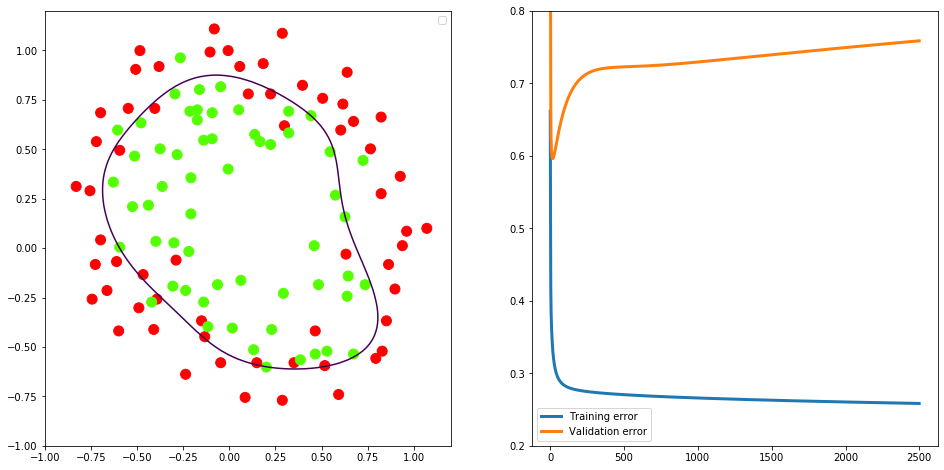

In [8]:
draw_regularization_example(X, Y)

### Regularyzacja

Regularyzacja jest metodą zapobiegania zjawisku nadmiernego dopasowania (*overfitting*) poprzez odpowiednie zmodyfikowanie funkcji kosztu.

Do funkcji kosztu dodawane jest specjalne wyrażenie (**wyrazenie regularyzacyjne** – zaznaczone na czerwono w poniższych wzorach), będące „karą” za ekstremalne wartości parametrów $\theta$.

W ten sposób preferowane są wektory $\theta$ z mniejszymi wartosciami parametrów – mają automatycznie niższy koszt.

Jak silną regularyzację chcemy zastosować? Możemy o tym zadecydować, dobierajac odpowiednio **parametr regularyzacji** $\lambda$.

### Regularyzacja dla regresji liniowej – funkcja kosztu

$$
J(\theta) \, = \, \dfrac{1}{2m} \left( \displaystyle\sum_{i=1}^{m} h_\theta(x^{(i)}) - y^{(i)} \color{red}{ + \lambda \displaystyle\sum_{j=1}^{n} \theta^2_j } \right)
$$

* $\lambda$ – parametr regularyzacji
* jeżeli $\lambda$ jest zbyt mały, skutkuje to nadmiernym dopasowaniem
* jeżeli $\lambda$ jest zbyt duży, skutkuje to niedostatecznym dopasowaniem

### Regularyzacja dla regresji liniowej – gradient

$$\small
\begin{array}{llll}
\dfrac{\partial J(\theta)}{\partial \theta_0} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_{\theta}(x^{(i)})-y^{(i)} \right) x^{(i)}_0 & \textrm{dla $j = 0$ }\\
\dfrac{\partial J(\theta)}{\partial \theta_j} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_{\theta}(x^{(i)})-y^{(i)} \right) x^{(i)}_j \color{red}{+ \dfrac{\lambda}{m}\theta_j} & \textrm{dla $j = 1, 2, \ldots, n $} \\
\end{array} 
$$

### Regularyzacja dla regresji logistycznej – funkcja kosztu

$$
\begin{array}{rtl}
J(\theta) & = & -\dfrac{1}{m} \left( \displaystyle\sum_{i=1}^{m} y^{(i)} \log h_\theta(x^{(i)}) + \left( 1-y^{(i)} \right) \log \left( 1-h_\theta(x^{(i)}) \right) \right) \\
& & \color{red}{ + \dfrac{\lambda}{2m} \displaystyle\sum_{j=1}^{n} \theta^2_j } \\
\end{array}
$$

### Regularyzacja dla regresji logistycznej – gradient

$$\small
\begin{array}{llll}
\dfrac{\partial J(\theta)}{\partial \theta_0} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_{\theta}(x^{(i)})-y^{(i)} \right) x^{(i)}_0 & \textrm{dla $j = 0$ }\\
\dfrac{\partial J(\theta)}{\partial \theta_j} &=& \dfrac{1}{m}\displaystyle\sum_{i=1}^m \left( h_{\theta}(x^{(i)})-y^{(i)} \right) x^{(i)}_j \color{red}{+ \dfrac{\lambda}{m}\theta_j} & \textrm{dla $j = 1, 2, \ldots, n $} \\
\end{array} 
$$

### Implementacja metody regularyzacji

In [9]:
def J_(h,theta,X,y,lamb=0):
    m = float(len(y))
    f = h(theta, X, eps=10**-7)
    j = 1.0/m \
        * -np.sum(np.multiply(y, np.log(f)) + 
                  np.multiply(1 - y, np.log(1 - f)), axis=0) \
        + lamb/(2*m) * np.sum(np.power(theta[1:] ,2))
    return j

def dJ_(h,theta,X,y,lamb=0):
    m = float(y.shape[0])
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    g[1:] += lamb/m * theta[1:]
    return g

In [10]:
slider_lambda = widgets.FloatSlider(min=0.0, max=0.5, step=0.005, value=0.01, description=r'$\lambda$', width=300)

def slide_regularization_example_2(lamb):
    draw_regularization_example(X, Y, lamb=lamb)

In [11]:
widgets.interact_manual(slide_regularization_example_2, lamb=slider_lambda)

interactive(children=(FloatSlider(value=0.01, description='$\\lambda$', max=0.5, step=0.005), Button(descripti…

<function __main__.slide_regularization_example_2(lamb)>

In [12]:
def cost_lambda_fun(lamb):
    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                         logError=True, validate=0.25, valStep=1, lamb=lamb)
    return err[1][-1], err[3][-1]

def plot_cost_lambda():
    plt.figure(figsize=(16,8))
    ax = plt.subplot(111)
    Lambda = np.arange(0.0, 1.0, 0.01)
    Costs = [cost_lambda_fun(lamb) for lamb in Lambda]
    CostTrain = [cost[0] for cost in Costs]
    CostCV = [cost[1] for cost in Costs]
    plt.plot(Lambda, CostTrain, lw=3, label='training error')
    plt.plot(Lambda, CostCV, lw=3, label='validation error')
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel(u'cost')
    plt.legend()
    plt.ylim(0.2,0.8)

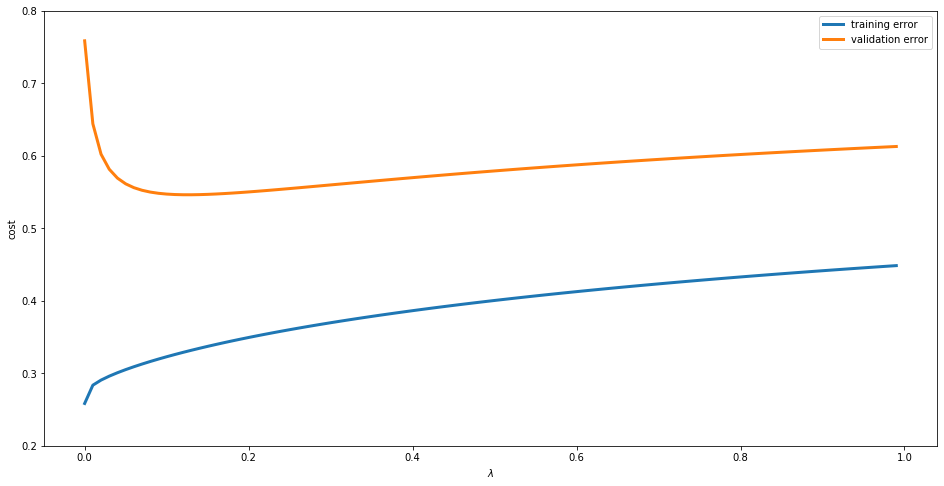

In [13]:
plot_cost_lambda()

## 5.3. Krzywa uczenia się

* Krzywa uczenia pozwala sprawdzić, czy uczenie przebiega poprawnie.
* Krzywa uczenia to wykres zależności między wielkością zbioru treningowego a wartością funkcji kosztu.
* Wraz ze wzrostem wielkości zbioru treningowego wartość funkcji kosztu na zbiorze treningowym rośnie.
* Wraz ze wzrostem wielkości zbioru treningowego wartość funkcji kosztu na zbiorze walidacyjnym maleje.

In [14]:
def cost_trainsetsize_fun(m):
    theta = np.matrix(np.zeros(X.shape[1])).reshape(X.shape[1],1)
    thetaBest, err = SGD(h, J, dJ, theta, X, Y, alpha=1, adaGrad=True, maxEpochs=2500, batchSize=100, 
                         logError=True, validate=0.25, valStep=1, lamb=0.01, trainsetsize=m)
    return err[1][-1], err[3][-1]

def plot_learning_curve():
    plt.figure(figsize=(16,8))
    ax = plt.subplot(111)
    M = np.arange(0.3, 1.0, 0.05)
    Costs = [cost_trainsetsize_fun(m) for m in M]
    CostTrain = [cost[0] for cost in Costs]
    CostCV = [cost[1] for cost in Costs]
    plt.plot(M, CostTrain, lw=3, label='training error')
    plt.plot(M, CostCV, lw=3, label='validation error')
    ax.set_xlabel(u'trainset size')
    ax.set_ylabel(u'cost')
    plt.legend()

### Krzywa uczenia a obciążenie i wariancja

Wykreślenie krzywej uczenia pomaga diagnozować nadmierne i niedostateczne dopasowanie:

<img width="100%" src="learning-curves.png"/>

Źródło: http://www.ritchieng.com/machinelearning-learning-curve

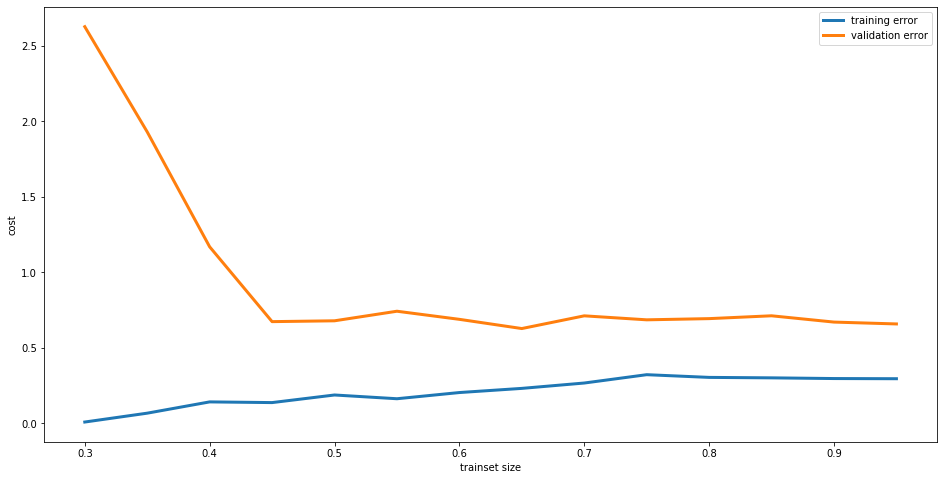

In [15]:
plot_learning_curve()

## 5.4. Obserwacje odstające

**Obserwacje odstające** (*outliers*) – to wszelkie obserwacje posiadające nietypową wartość.

Mogą być na przykład rezultatem błędnego pomiaru albo pomyłki przy wprowadzaniu danych do bazy, ale nie tylko.

Obserwacje odstające mogą niekiedy znacząco wpłynąć na parametry modelu, dlatego ważne jest, żeby takie obserwacje odrzucić zanim przystąpi się do tworzenia modelu.

W poniższym przykładzie można zobaczyć wpływ obserwacji odstających na wynik modelowania na przykładzie danych dotyczących cen mieszkań zebranych z ogłoszeń na portalu Gratka.pl: tutaj przykładem obserwacji odstającej może być ogłoszenie, w którym podano cenę w tys. zł zamiast ceny w zł.

In [16]:
# Funkcja regresji liniowej

def h_linear(Theta, x):
    return x * Theta

def linear_regression(theta):
    return lambda x: h_linear(theta, x)

# Wykres krzywej regresji (wersja macierzowa)
def plot_regression(fig, fun, theta, X):
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

In [17]:
# Wczytanie danych (mieszkania) przy pomocy biblioteki pandas

alldata = pandas.read_csv('data_flats_with_outliers.tsv', sep='\t',
                         names=['price', 'isNew', 'rooms', 'floor', 'location', 'sqrMetres'])
data = np.matrix(alldata[['price', 'sqrMetres']])

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 0:n]

Xo = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n + 1)
yo = np.matrix(data[:, -1]).reshape(m, 1)

Xo /= np.amax(Xo, axis=0)
yo /= np.amax(yo, axis=0)

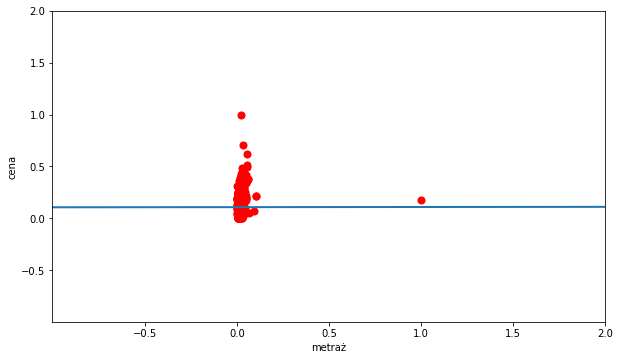

In [18]:
fig = plot_data(Xo, yo, xlabel=u'metraż', ylabel=u'cena')
theta_start = np.matrix([0.0, 0.0]).reshape(2, 1)
theta, logs = gradient_descent(cost, gradient, theta_start, Xo, yo, alpha=0.01)
plot_regression(fig, h_linear, theta, Xo)

Na powyższym przykładzie obserwacja odstająca jawi sie jako pojedynczy punkt po prawej stronie wykresu. Widzimy, że otrzymana krzywa regresji zamiast odwzorowywać ogólny trend, próbuje „dopasować się” do tej pojedynczej obserwacji.

Dlatego taką obserwację należy usunąć ze zbioru danych (zobacz ponizej).

In [19]:
# Odrzućmy obserwacje odstające
alldata_no_outliers = [
    (index, item) for index, item in alldata.iterrows() 
    if item.price > 100 and item.sqrMetres > 10]

alldata_no_outliers = alldata.loc[(alldata['price'] > 100) & (alldata['sqrMetres'] > 100)]

In [20]:
data = np.matrix(alldata_no_outliers[['price', 'sqrMetres']])

m, n_plus_1 = data.shape
n = n_plus_1 - 1
Xn = data[:, 0:n]

Xo = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n + 1)
yo = np.matrix(data[:, -1]).reshape(m, 1)

Xo /= np.amax(Xo, axis=0)
yo /= np.amax(yo, axis=0)

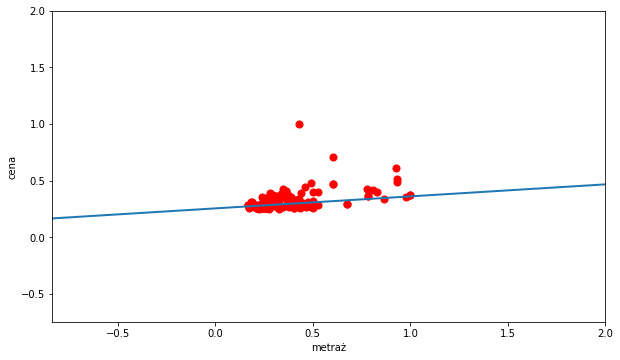

In [21]:
fig = plot_data(Xo, yo, xlabel=u'metraż', ylabel=u'cena')
theta_start = np.matrix([0.0, 0.0]).reshape(2, 1)
theta, logs = gradient_descent(cost, gradient, theta_start, Xo, yo, alpha=0.01)
plot_regression(fig, h_linear, theta, Xo)

Na powyższym wykresie widać, że po odrzuceniu obserwacji odstających otrzymujemy dużo bardziej „wiarygodną” krzywą regresji.

## 5.5. Miary jakości

Aby przeprowadzić ewaluację modelu, musimy wybrać **miarę** (**metrykę**), jakiej będziemy używać.

Jakiej miary użyc najlepiej?
 * To zależy od rodzaju zadania.
 * Innych metryk używa się do regresji, a innych do klasyfikacji

### Metryki dla zadań regresji

Dla zadań regresji możemy zastosować np.:
 * błąd średniokwadratowy (*root-mean-square error*, RMSE):
   $$ \mathrm{RMSE} \, = \, \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left( \hat{y}^{(i)} - y^{(i)} \right)^2 } $$
 * średni błąd bezwzględny (*mean absolute error*, MAE):
   $$ \mathrm{MAE} \, = \, \frac{1}{m} \sum_{i=1}^{m} \left| \hat{y}^{(i)} - y^{(i)} \right| $$

W powyższych wzorach $y^{(i)}$ oznacza **oczekiwaną** wartości zmiennej $y$ w $i$-tym przykładzie, a $\hat{y}^{(i)}$ oznacza wartość zmiennej $y$ w $i$-tym przykładzie wyliczoną (**przewidzianą**) przez nasz model.

### Metryki dla zadań klasyfikacji

Aby przedstawić kilka najpopularniejszych metryk stosowanych dla zadań klasyfikacyjnych, posłużmy się następującym przykładem:

In [22]:
# Przydatne importy

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas
import random
import seaborn

%matplotlib inline

In [23]:
def powerme(x1,x2,n):
    X = []
    for m in range(n+1):
        for i in range(m+1):
            X.append(np.multiply(np.power(x1,i),np.power(x2,(m-i))))
    return np.hstack(X)

In [24]:
# Wykres danych
def plot_data_for_classification(X, Y, xlabel=None, ylabel=None, Y_predicted=[], highlight=None):
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    X = X.tolist()
    Y = Y.tolist()
    X1n = [x[1] for x, y in zip(X, Y) if y[0] == 0]
    X1p = [x[1] for x, y in zip(X, Y) if y[0] == 1]
    X2n = [x[2] for x, y in zip(X, Y) if y[0] == 0]
    X2p = [x[2] for x, y in zip(X, Y) if y[0] == 1]
    
    if len(Y_predicted) > 0:
        Y_predicted = Y_predicted.tolist()
        X1tn = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 0]
        X1fn = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 0]
        X1tp = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 1]
        X1fp = [x[1] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 1]
        X2tn = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 0]
        X2fn = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 0]
        X2tp = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 1 and yp[0] == 1]
        X2fp = [x[2] for x, y, yp in zip(X, Y, Y_predicted) if y[0] == 0 and yp[0] == 1]
    
        if highlight == 'tn':
            ax.scatter(X1tn, X2tn, c='r', marker='x', s=100, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'fn':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='g', marker='o', s=100, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'tp':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='g', marker='o', s=100, label='Dane')
            ax.scatter(X1fp, X2fp, c='k', marker='x', s=50, label='Dane')
        elif highlight == 'fp':
            ax.scatter(X1tn, X2tn, c='k', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='k', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='r', marker='x', s=100, label='Dane')
        else:
            ax.scatter(X1tn, X2tn, c='r', marker='x', s=50, label='Dane')
            ax.scatter(X1fn, X2fn, c='g', marker='o', s=50, label='Dane')
            ax.scatter(X1tp, X2tp, c='g', marker='o', s=50, label='Dane')
            ax.scatter(X1fp, X2fp, c='r', marker='x', s=50, label='Dane')

    else:
        ax.scatter(X1n, X2n, c='r', marker='x', s=50, label='Dane')
        ax.scatter(X1p, X2p, c='g', marker='o', s=50, label='Dane')
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    ax.margins(.05, .05)
    return fig

In [25]:
# Wczytanie danych
import pandas
import numpy as np

alldata = pandas.read_csv('data-metrics.tsv', sep='\t')
data = np.matrix(alldata)

m, n_plus_1 = data.shape
n = n_plus_1 - 1

X2 = powerme(data[:, 1], data[:, 2], n)
Y2 = np.matrix(data[:, 0]).reshape(m, 1)

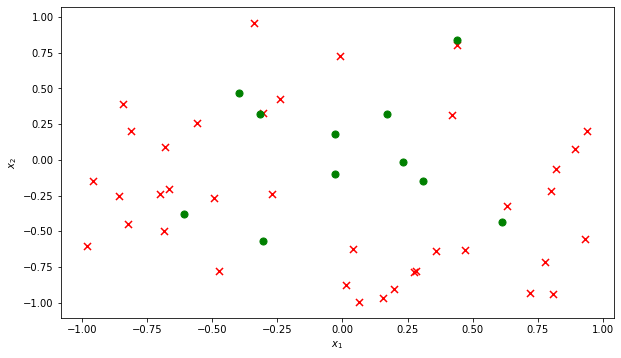

In [26]:
fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$')

In [27]:
def safeSigmoid(x, eps=0):
    y = 1.0/(1.0 + np.exp(-x))
    if eps > 0:
        y[y < eps] = eps
        y[y > 1 - eps] = 1 - eps
    return y

def h(theta, X, eps=0.0):
    return safeSigmoid(X*theta, eps)

def J(h,theta,X,y, lamb=0):
    m = len(y)
    f = h(theta, X, eps=10**-7)
    j = -np.sum(np.multiply(y, np.log(f)) + 
                np.multiply(1 - y, np.log(1 - f)), axis=0)/m
    if lamb > 0:
        j += lamb/(2*m) * np.sum(np.power(theta[1:],2))
    return j

def dJ(h,theta,X,y,lamb=0):
    g = 1.0/y.shape[0]*(X.T*(h(theta,X)-y))
    if lamb > 0:
        g[1:] += lamb/float(y.shape[0]) * theta[1:] 
    return g

def classifyBi(theta, X):
    prob = h(theta, X)
    return prob

In [28]:
# Metoda gradientu prostego dla regresji logistycznej
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

In [29]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_start = np.matrix(np.zeros(X2.shape[1])).reshape(X2.shape[1],1)
theta, errors = GD(h, J, dJ, theta_start, X2, Y2, 
                       alpha=0.1, eps=10**-7, maxSteps=10000)
print('theta = {}'.format(theta))

theta = [[ 1.37136167]
 [ 0.90128948]
 [ 0.54708112]
 [-5.9929264 ]
 [ 2.64435168]
 [-4.27978238]]


In [30]:
# Wykres granicy klas
def plot_decision_boundary(fig, theta, X):
    ax = fig.axes[0]
    xx, yy = np.meshgrid(np.arange(-1.0, 1.0, 0.02),
                         np.arange(-1.0, 1.0, 0.02))
    l = len(xx.ravel())
    C = powerme(xx.reshape(l, 1), yy.reshape(l, 1), n)
    z = classifyBi(theta, C).reshape(int(np.sqrt(l)), int(np.sqrt(l)))

    plt.contour(xx, yy, z, levels=[0.5], lw=3);

In [31]:
Y_expected = Y2.astype(int)
Y_predicted = (classifyBi(theta, X2) > 0.5).astype(int)

In [32]:
# Przygotowanie interaktywnego wykresu

dropdown_highlight = widgets.Dropdown(options=['all', 'tp', 'fp', 'tn', 'fn'], value='all', description='highlight')

def interactive_classification(highlight):
    fig = plot_data_for_classification(X2, Y2, xlabel=r'$x_1$', ylabel=r'$x_2$',
                                       Y_predicted=Y_predicted, highlight=highlight)
    plot_decision_boundary(fig, theta, X2)

/home/pawel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'lw'
  # Remove the CWD from sys.path while we load stuff.


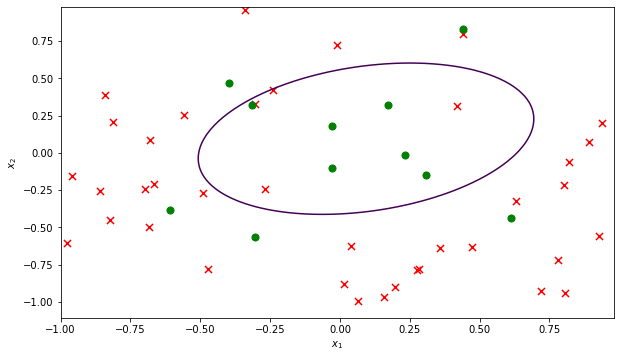

<function __main__.interactive_classification(highlight)>

In [33]:
widgets.interact(interactive_classification, highlight=dropdown_highlight)

Zadanie klasyfikacyjne z powyższego przykładu polega na przypisaniu punktów do jednej z dwóch kategorii:
 0. <font color="red">czerwone krzyżyki</font>
 1. <font color="green">zielone kółka</font>

W tym celu zastosowano regresję logistyczną.

W rezultacie otrzymano model, który dzieli płaszczyznę na dwa obszary:
 0. <font color="red">na zewnątrz granatowej krzywej</font>
 1. <font color="green">wewnątrz granatowej krzywej</font>
 
Model przewiduje klasę <font color="red">0 („czerwoną”)</font> dla punktów znajdujący się w obszarze na zewnątrz krzywej, natomiast klasę <font color="green">1 („zieloną”)</font> dla punktów znajdujących sie w obszarze wewnąrz krzywej.

Wszysktie obserwacje możemy podzielić zatem na cztery grupy:
 * **true positives (TP)** – prawidłowo sklasyfikowane pozytywne przykłady (<font color="green">zielone kółka</font> w <font color="green">wewnętrznym obszarze</font>)
 * **true negatives (TN)** – prawidłowo sklasyfikowane negatywne przykłady (<font color="red">czerwone krzyżyki</font> w <font color="red">zewnętrznym obszarze</font>)
 * **false positives (FP)** – negatywne przykłady sklasyfikowane jako pozytywne (<font color="red">czerwone krzyżyki</font> w <font color="green">wewnętrznym obszarze</font>)
 * **false negatives (FN)** – pozytywne przykłady sklasyfikowane jako negatywne (<font color="green">zielone kółka</font> w <font color="red">zewnętrznym obszarze</font>)

Innymi słowy:

<img width="50%" src="https://blog.aimultiple.com/wp-content/uploads/2019/07/positive-negative-true-false-matrix.png">

In [34]:
# Obliczmy TP, TN, FP i FN

tp = 0
tn = 0
fp = 0
fn = 0

for i in range(len(Y_expected)):
    if Y_expected[i] == 1 and Y_predicted[i] == 1:
        tp += 1
    elif Y_expected[i] == 0 and Y_predicted[i] == 0:
        tn += 1
    elif Y_expected[i] == 0 and Y_predicted[i] == 1:
        fp += 1
    elif Y_expected[i] == 1 and Y_predicted[i] == 0:
        fn += 1
        
print('TP =', tp)
print('TN =', tn)
print('FP =', fp)
print('FN =', fn)

TP = 5
TN = 35
FP = 3
FN = 6


Możemy teraz zdefiniować następujące metryki:

#### Dokładność (_accuracy_)
$$ \mbox{accuracy} = \frac{\mbox{przypadki poprawnie sklasyfikowane}}{\mbox{wszystkie przypadki}} = \frac{TP + TN}{TP + TN + FP + FN} $$

Dokładność otrzymujemy przez podzielenie liczby przypadków poprawnie sklasyfikowanych przez liczbę wszystkich przypadków:

In [35]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('Accuracy:', accuracy)

Accuracy: 0.8163265306122449


**Uwaga:** Nie zawsze dokładność będzie dobrą miarą, zwłaszcza gdy klasy są bardzo asymetryczne!

*Przykład:* Wyobraźmy sobie test na koronawirusa, który **zawsze** zwraca wynik negatywny. Jaką przydatność będzie miał taki test w praktyce? Żadną. A jaka będzie jego *dokładność*? Policzmy:
$$ \mbox{accuracy} \, = \, \frac{\mbox{szacowana liczba osób zdrowych na świecie}}{\mbox{populacja Ziemi}} \, \approx \, \frac{7\,700\,000\,000 - 600\,000}{7\,700\,000\,000} \, \approx \, 0.99992 $$
(zaokrąglone dane z 27 marca 2020)

Powyższy wynik jest tak wysoki, ponieważ zdecydowana większość osób na świecie nie jest zakażona, więc biorąc losowego Ziemianina możemy w ciemno strzelać, że nie ma koronawirusa.

W tym przypadku duża różnica w liczności obu zbiorów (zakażeni/niezakażeni) powoduje, że *accuracy* nie jest dobrą metryką.

Dlatego dysponujemy również innymi metrykami:

#### Precyzja (_precision_)
$$ \mbox{precision} = \frac{TP}{TP + FP} $$

In [36]:
precision = tp / (tp + fp)
print('Precision:', precision)

Precision: 0.625


Precyzja określa, jaka część przykładów sklasyfikowanych jako pozytywne to faktycznie przykłady pozytywne.

#### Pokrycie (czułość, _recall_)
$$ \mbox{recall} = \frac{TP}{TP + FN} $$

In [37]:
recall = tp / (tp + fn)
print('Recall:', recall)

Recall: 0.45454545454545453


Pokrycie mówi nam, jaka część przykładów pozytywnych została poprawnie sklasyfikowana.

#### _$F$-measure_ (_$F$-score_)
$$ F = \frac{2 \cdot \mbox{precision} \cdot \mbox{recall}}{\mbox{precision} + \mbox{recall}} $$

In [38]:
fscore = (2 * precision * recall) / (precision + recall)
print('F-score:', fscore)

F-score: 0.5263157894736842


$F$-_measure_ jest kompromisem między precyzją a pokryciem (a ściślej: jest średnią harmoniczną precyzji i pokrycia).

$F$-_measure_ jest szczególnym przypadkiem ogólniejszej miary:

_$F_\beta$-measure_:
$$ F_\beta = \frac{(1 + \beta) \cdot \mbox{precision} \cdot \mbox{recall}}{\beta^2 \cdot \mbox{precision} + \mbox{recall}} $$

Dla $\beta = 1$ otrzymujemy:
$$ F_1 \, = \, \frac{(1 + 1) \cdot \mbox{precision} \cdot \mbox{recall}}{1^2 \cdot \mbox{precision} + \mbox{recall}} \, = \, \frac{2 \cdot \mbox{precision} \cdot \mbox{recall}}{\mbox{precision} + \mbox{recall}} \, = \, F $$